In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.utils import create_data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
X, y = create_data()
random_state = 42

pca = PCA()
pca_result = pca.fit_transform(X) # Perform PCA

(70000, 784)
(70000,)


# Observation + Feature Viz

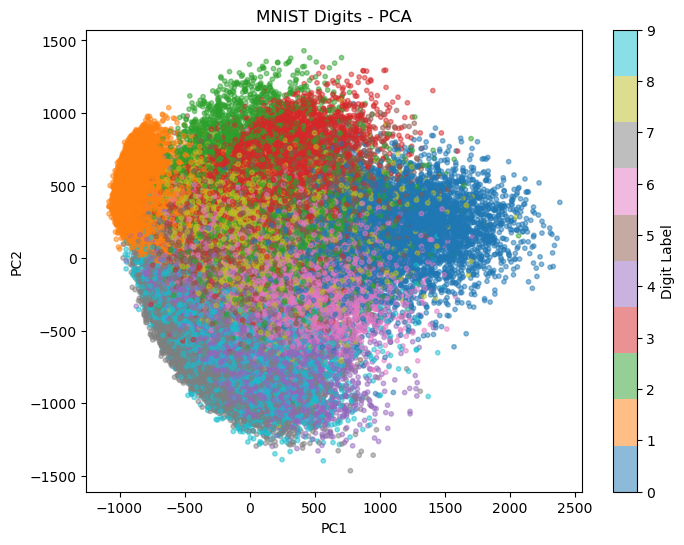

In [16]:
def plot_pc1_pc2(X : pd.DataFrame, path : str, random_state : int = 42):
    pca = PCA(n_components=2, random_state=random_state) # return 2 components
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=y, cmap="tab10", s=10, alpha=0.5)
    plt.colorbar(scatter, label="Digit Label")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("MNIST Digits - PCA")
    plt.savefig(path)
    plt.show()

plot_pc1_pc2(X=X, path='docs/pc1_pc2_labeled.png')

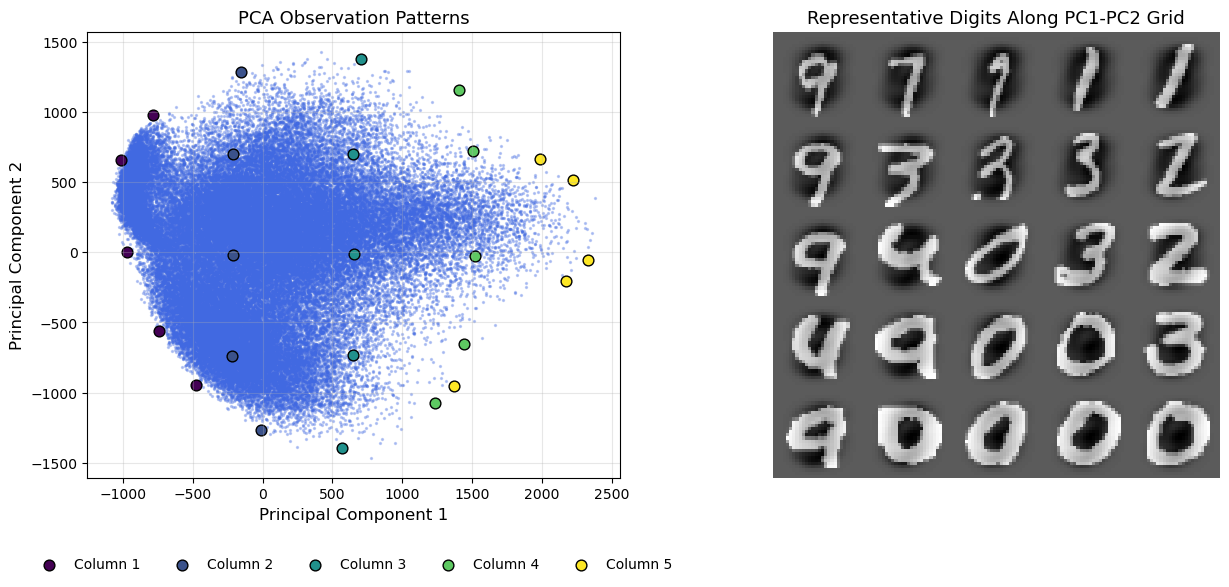

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

random_state = 42
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
X_centered = StandardScaler(with_std=False).fit_transform(X)

pca = PCA(n_components=10, random_state=random_state)
pca_result = pca.fit_transform(X_centered)

L = np.linspace(np.min(pca_result[:, 0]), np.max(pca_result[:, 0]), 5)
M = np.linspace(np.min(pca_result[:, 1]), np.max(pca_result[:, 1]), 5)
select = np.zeros((len(L), len(M)), dtype=int)

for i in range(len(L)):
    for j in range(len(M)):
        d = (pca_result[:, 0] - L[i])**2 + (pca_result[:, 1] - M[j])**2
        select[i, j] = np.argmin(d)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
ax, ax2 = axes

ax.scatter(pca_result[:, 0], pca_result[:, 1],
           s=2, alpha=0.3, color='royalblue')

row_colors = plt.cm.viridis(np.linspace(0, 1, len(L)))

for i, color in enumerate(row_colors):
    ax.scatter(pca_result[select[i, :], 0],
               pca_result[select[i, :], 1],
               color=color, s=60, edgecolor='black',
               label=f'Column {i+1}')

ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_title("PCA Observation Patterns", fontsize=13)
ax.legend(frameon=False,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15),
          ncol=len(L+1))

ax.grid(True, alpha=0.3)
grid_size = len(L)
img_grid = np.zeros((28 * grid_size, 28 * grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        img = X_centered[select[i, j]].reshape(28, 28)
        y_start, y_end = i * 28, (i + 1) * 28
        x_start, x_end = j * 28, (j + 1) * 28
        img_grid[y_start:y_end, x_start:x_end] = img

ax2.imshow(img_grid, cmap='gray', aspect='equal')
ax2.set_title("Representative Digits Along PC1-PC2 Grid", fontsize=13)
ax2.axis('off')

plt.tight_layout()
plt.savefig('docs/pc1_pc2_patterns.png')
plt.show()

# Hyperparameter tuning

In [36]:
# ==========================
# 1. REFRESH
# ==========================

X, y = create_data()
random_state = 42

(70000, 784)
(70000,)


In [ ]:
# ====================================================
# 2. HYPERPARAMETER TUNING - SUPERVISED
# ====================================================

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
pca = PCA(n_components=None, svd_solver='randomized', random_state=random_state) # return ALL components
Z_tr = pca.fit_transform(X_tr)
Z_ts = pca.transform(X_ts)

## 
k_list = range(5, 105, 5)
accs = []
multinomial = LogisticRegression(max_iter=1000, verbose=False)
for k in k_list:
    # Scaling DRASTICALLY improves runntime without harming accuracy
    scaler_pca = StandardScaler()
    Z_components_tr = scaler_pca.fit_transform(Z_tr[:, :k])
    Z_components_ts = scaler_pca.transform(Z_ts[:, :k])
    multinomial.fit(Z_components_tr, y_tr)
    iteration_acc = accuracy_score(y_ts, multinomial.predict(Z_components_ts))
    accs.append(iteration_acc)
    print(f'iter : k = {k}')

iter : k = 5
iter : k = 10
iter : k = 15
iter : k = 20
iter : k = 25
iter : k = 30
iter : k = 35
iter : k = 40
iter : k = 45
iter : k = 50
iter : k = 55
iter : k = 60
iter : k = 65
iter : k = 70
iter : k = 75
iter : k = 80
iter : k = 85
iter : k = 90
iter : k = 95
iter : k = 100


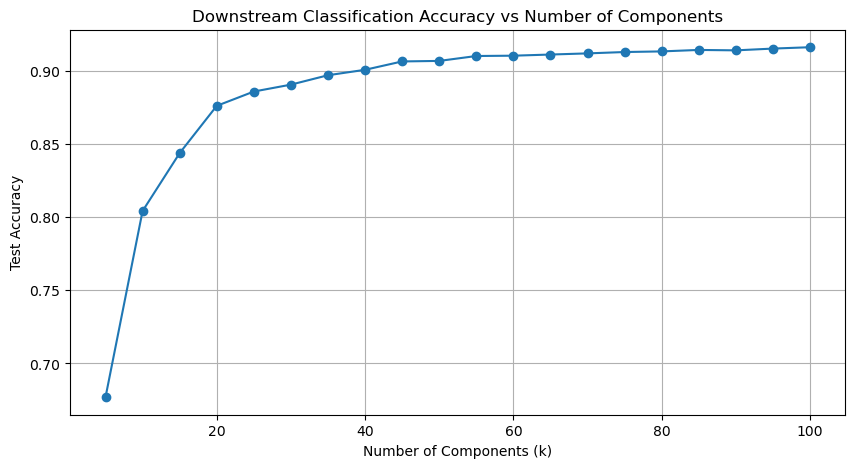

In [40]:
def plot_classification_accuracy_on_number_of_components(path : str):
    plt.figure(figsize=(10,5))
    plt.plot(k_list, accs, marker='o')
    plt.xlabel("Number of Components (k)")
    plt.ylabel("Test Accuracy")
    plt.title("Downstream Classification Accuracy vs Number of Components")
    plt.grid(True)
    plt.savefig(path)
    plt.show()
plot_classification_accuracy_on_number_of_components(path = 'docs/hyperparam_tune_supervised_pca.png')